# Fetch data

In [12]:
import pandas as pd; import numpy as np; import scipy
credit_data = pd.read_csv('../data/credit_risk_dataset.csv')

credit_data

# person_age	                    Age
# person_income                     Annual Income
# person_home_ownership	            Home ownership
# person_emp_length	                Employment length (in years)
# loan_intent	                    Loan intent
# loan_grade	                    Loan grade
# loan_amnt	                        Loan amount
# loan_int_rate	                    Interest rate
# loan_status	                  Loan status (0 is non default 1 is default)
# loan_percent_income	            Percent income
# cb_person_default_on_file	        Historical default
# cb_preson_cred_hist_length	    Credit history length

credit_data
matplotlib.__version__
scipy.__version__

'1.14.1'

Initial lookup

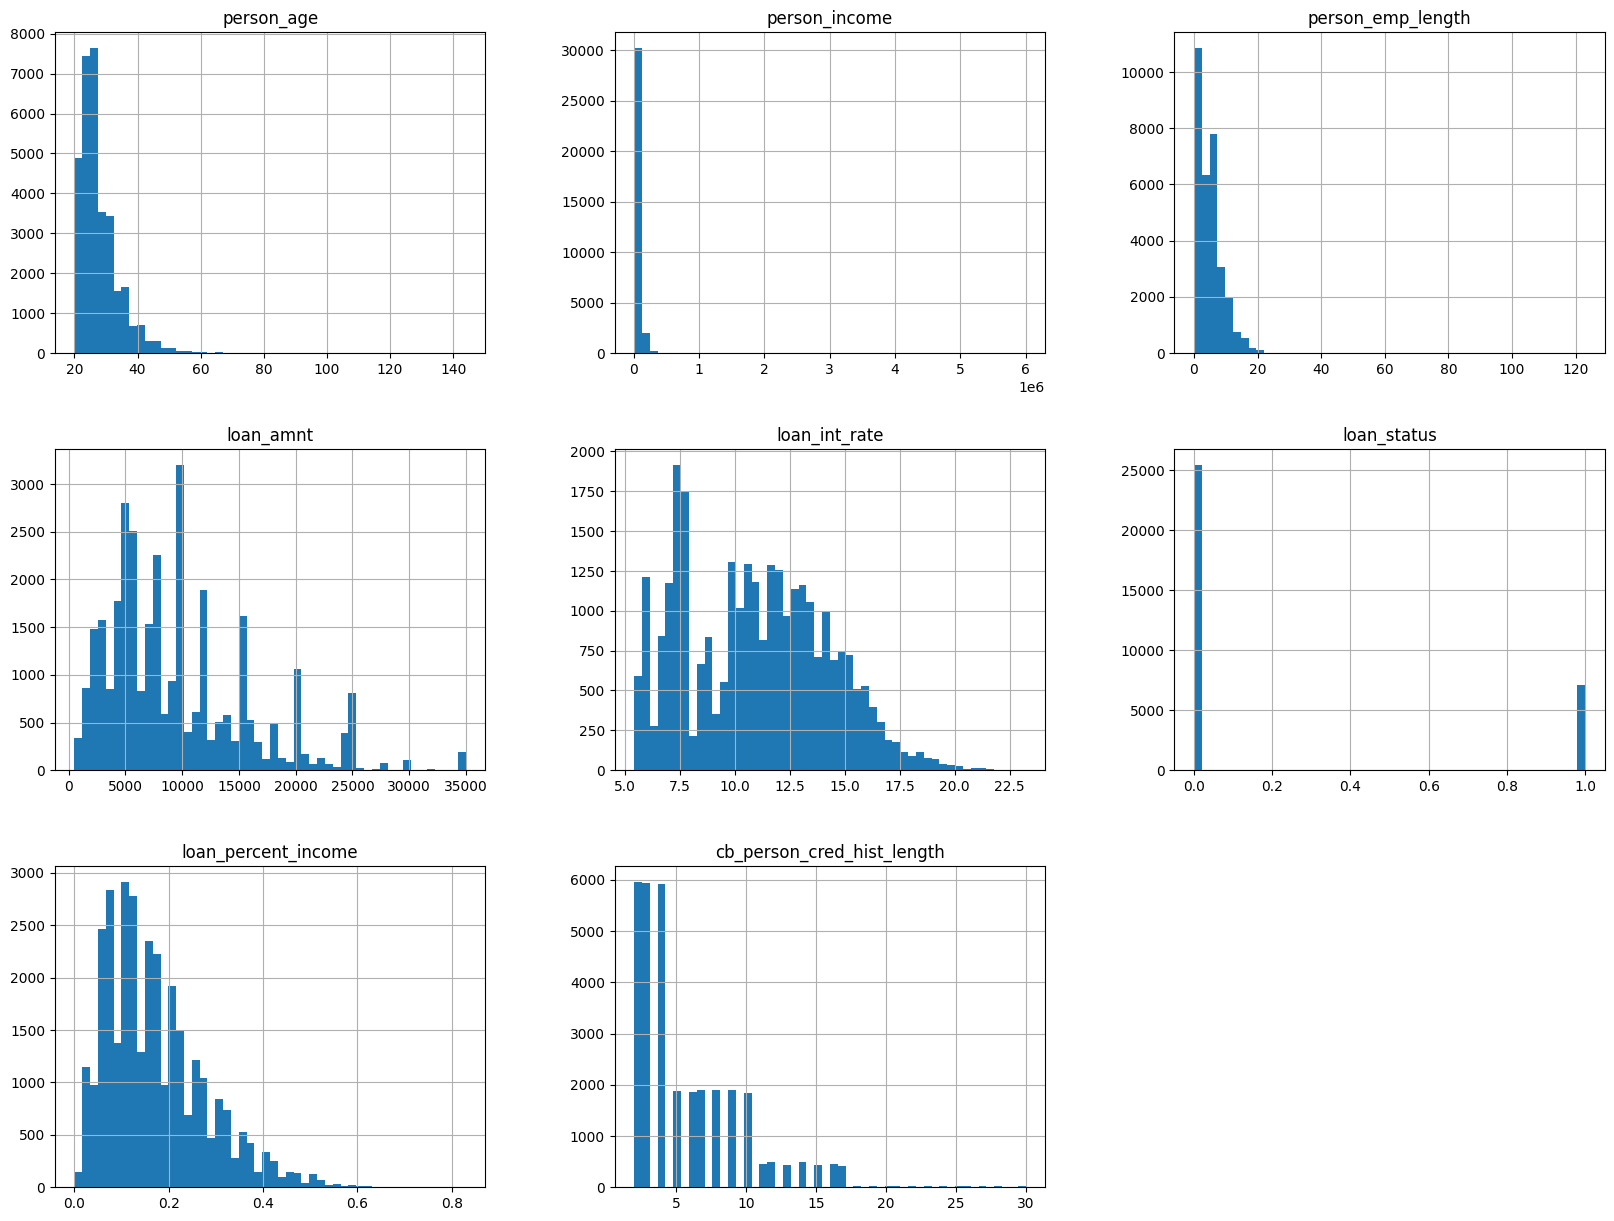

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt

credit_data.hist(bins=50, figsize=(20,15))

plt.show()

# Split train/test

In [240]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(credit_data, test_size=0.2, random_state=42, stratify=credit_data['loan_status']) # stratify to keep the same distribution of the target variable

print(len(train_set), "train +", len(test_set), "test")

print(train_set['loan_status'].value_counts() / len(train_set))

train_set.isna().sum()


26064 train + 6517 test
loan_status
0    0.781845
1    0.218155
Name: count, dtype: float64


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              738
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2501
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

# Gaining insights

Checking out the categorical features

In [241]:
train_set_copy = train_set.copy() # create a copy of the training set to avoid modifying the original data

for col in train_set_copy.columns:
    
    by_feature = train_set_copy.groupby(col)['loan_status'].value_counts(normalize=True)

    print(by_feature)

# (loan_intent)
# venture has the lowest default rate, followed by education, personal.
# followed by home improvement, medical and debt consolidation being fairly equal at the top

# (person_home_ownership)
# people who own a home and people who have a mortgage have a lower default rate, while people who rent and people from 'Other' section have a higher default rate

# (cb_person_default_on_file)
# people with default on file have a higher default rate

# (loan_grade)
# people with A grade have the lowest default rate, followed by B, C, D, E, F and G

person_age  loan_status
20          0              0.833333
            1              0.166667
21          0              0.702513
            1              0.297487
22          0              0.754561
                             ...   
76          0              1.000000
84          0              1.000000
94          0              1.000000
123         0              1.000000
144         0              1.000000
Name: proportion, Length: 100, dtype: float64
person_income  loan_status
4000           1              1.0
4080           1              1.0
4200           1              1.0
4800           1              1.0
4888           1              1.0
                             ... 
1200000        0              1.0
1440000        0              1.0
1782000        0              1.0
2039784        0              1.0
6000000        0              1.0
Name: proportion, Length: 4173, dtype: float64
person_home_ownership  loan_status
MORTGAGE               0              0.876111
    

Checking out the numerical features using Pearson's Correlation

In [242]:
corr_matrix = train_set_copy.select_dtypes(include=['float64', 'int64']).corr()
corr_matrix['loan_status'].sort_values(ascending=False)

# the loans with higher loan-to-income ratio and higher interest rates have a higher default rate (0.37 and 0.33 respectively) followed by loan amount (0.10). people with lower income and employment length have a higher default rate (-0.14 and -0.08 respectively)

loan_status                   1.000000
loan_percent_income           0.379378
loan_int_rate                 0.330949
loan_amnt                     0.107205
cb_person_cred_hist_length   -0.013857
person_age                   -0.019010
person_emp_length            -0.081877
person_income                -0.140955
Name: loan_status, dtype: float64

Trying out different combinations of features

In [243]:
# people from mid or upper class have a lower default rate
train_set_copy['mid_upper_class'] = ((train_set_copy['loan_grade'] == 'A') | (train_set_copy['loan_grade'] == 'B')) & (train_set_copy['person_income'] > train_set_copy['person_income'].median())

train_set_copy.groupby('mid_upper_class')['loan_status'].value_counts(normalize=True)


train_set_copy['student'] = ((train_set_copy['loan_intent'] == 'EDUCATION')) & (train_set_copy['person_age'] < 25)

# students have a lower default rate
train_set_copy.groupby('student')['loan_status'].value_counts(normalize=True)

# interest rates are pretty much the same for all loan intents
train_set_copy.groupby('loan_intent')['loan_int_rate'].mean()

train_set_copy.groupby(['loan_intent', 'person_home_ownership'])['loan_status'].value_counts(normalize=True) # theres something interesting combinations here

train_set_copy.groupby(['loan_grade', 'cb_person_default_on_file'])['loan_int_rate'].mean() # theres something interesting combinations here

train_set_copy['income_grade'] = pd.cut(train_set_copy['person_income'], bins=[0, 10000, 20000, 25000, 40000, 55000, 70000, np.inf], labels=[1,2,3,4,5,6,7])

train_set_copy.groupby(['loan_grade'])['loan_amnt'].median() # theres something interesting combinations here

train_set_copy['AgeBucket'] = train_set_copy['person_age'] // 10 * 10

train_set_copy.groupby(['AgeBucket'])['loan_status'].value_counts(normalize=True)


AgeBucket  loan_status
20         0              0.776939
           1              0.223061
30         0              0.798064
           1              0.201936
40         0              0.789184
           1              0.210816
50         0              0.756345
           1              0.243655
60         0              0.634615
           1              0.365385
70         0              0.777778
           1              0.222222
80         0              1.000000
90         0              1.000000
120        0              1.000000
140        0              1.000000
Name: proportion, dtype: float64

Before moving on, its important to find out which loans are defaulted the most

In [244]:
train_set_copy['loan_group'] = pd.cut(train_set_copy['loan_percent_income'], bins=[0, train_set_copy['loan_percent_income'].quantile(0.2), train_set_copy['loan_percent_income'].quantile(0.4), train_set_copy['loan_percent_income'].quantile(0.6), train_set_copy['loan_percent_income'].quantile(0.8), train_set_copy['loan_percent_income'].max()], labels=['low', 'low-mid', 'mid', 'mid-high', 'high'])
train_set_copy.groupby('loan_group')['loan_status'].mean()

# higher loan amount has a higher default rate

C:\Users\User\AppData\Local\Temp\ipykernel_12556\3803159869.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_set_copy.groupby('loan_group')['loan_status'].mean()


loan_group
low         0.114551
low-mid     0.123573
mid         0.152178
mid-high    0.191754
high        0.531156
Name: loan_status, dtype: float64

Seperate X and y 

In [245]:
X_train = train_set.drop(['loan_status'], axis=1)
y_train = train_set['loan_status']


X_test = test_set.drop(['loan_status'], axis=1)
y_test = test_set['loan_status']


Before transformation

In [246]:
X_train

# Plan:

# person_age - standardize
# person_income - standardize
# person_home_ownership - one hot encoding
# person_emp_length - fill with median, standardize
# loan_intent - one hot encoding
# loan_grade - one hot encoding
# loan_amnt - standardize
# loan_int_rate - fill with median, standardize
# loan_percent_income - standardize
# cb_person_default_on_file - one hot encoding
# cb_person_cred_hist_length - standardize

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15884,25,241875,MORTGAGE,4.0,EDUCATION,A,16000,7.05,0.07,N,4
15138,21,18000,RENT,5.0,PERSONAL,B,1500,12.18,0.08,N,4
7474,25,53000,MORTGAGE,10.0,MEDICAL,B,16000,12.53,0.30,N,2
18212,28,16800,OWN,NaN,MEDICAL,C,5000,13.98,0.30,N,8
6493,25,50000,MORTGAGE,2.0,VENTURE,A,10000,7.90,0.20,N,2
...,...,...,...,...,...,...,...,...,...,...,...
14621,25,98000,MORTGAGE,9.0,HOMEIMPROVEMENT,E,25000,16.45,0.26,N,4
18736,30,65000,RENT,0.0,MEDICAL,C,16000,13.06,0.25,N,8
1663,22,20000,RENT,7.0,EDUCATION,A,1675,7.74,0.08,N,3
18257,29,110000,RENT,4.0,HOMEIMPROVEMENT,E,24000,18.39,0.22,Y,8


# Data preprocessing

In [247]:
"""
This code snippet demonstrates the construction of a machine learning pipeline for credit risk assessment. It includes data preprocessing steps such as scaling, encoding, and dropping columns. The pipeline consists of custom transformers and utilizes various modules from the scikit-learn library.
Functions:
- CustomColumnModifier: A custom transformer to modify specific columns in the dataset.
- CustomColumnTransformer: A custom transformer to drop columns and perform additional transformations.
- fill_scale_encode: ColumnTransformer object that applies median imputation, scaling, and one-hot encoding to specified columns, while dropping other columns.
- pipeline: Pipeline object that combines the fill_scale_encode transformer with the CustomColumnTransformer.
Variables:
- columns_to_scale: List of column names to be scaled.
- columns_to_encode: List of column names to be one-hot encoded.
- columns_to_drop: List of column names to be dropped.
- age_mean, age_std, income_mean, income_std, emp_length_mean, emp_length_std, percent_income_mean, percent_income_std, interest_mean, interest_std: Variables storing the mean and standard deviation of specific columns in the training data.
Usage:
1. Instantiate the CustomColumnModifier and CustomColumnTransformer classes.
2. Create the fill_scale_encode ColumnTransformer object, specifying the desired imputation, scaling, and encoding strategies.
3. Create the pipeline object, combining the fill_scale_encode transformer with the CustomColumnTransformer.
4. Fit and transform the training data using the pipeline.
5. Convert the transformed data to a numpy array or sparse matrix.
6. Retrieve the interest rates in the original scale.
Note: This code snippet assumes the existence of a training dataset X_train and a target variable y_train_interest.
"""


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix

columns_to_scale = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income', 'loan_int_rate']

columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade']

columns_to_drop = ['cb_person_default_on_file', 'loan_amnt', 'cb_person_cred_hist_length']

# save some variables that will be useful later
age_mean = X_train['person_age'].mean()
age_std = X_train['person_age'].std()
income_mean = X_train['person_income'].mean()
income_std = X_train['person_income'].std()
emp_length_mean = X_train['person_emp_length'].mean()
emp_length_std = X_train['person_emp_length'].std()
percent_income_mean = X_train['loan_percent_income'].mean()
percent_income_std = X_train['loan_percent_income'].std()
interest_mean = X_train['loan_int_rate'].mean() 
interest_std = X_train['loan_int_rate'].std()


class CustomColumnModifier(BaseEstimator, TransformerMixin): # custom transformer to modify some columns. We do this to make the dataset closer to reality

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        X_df = X.copy()

        return X_df
        

class CustomColumnTransformer(BaseEstimator, TransformerMixin): # custom transformer to drop some columns
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        X_df = pd.DataFrame(X, columns=fill_scale_encode.get_feature_names_out())

        X_df['student'] = ((X_df['loan_intent_EDUCATION'] == 1) & (X_df['person_age'] < 25)).astype(float) 

        X_interest = X_df['loan_int_rate'].copy()
        
        X_df.drop(['loan_intent_PERSONAL', 'loan_int_rate'], 
        axis=1, inplace=True)
        
        return X_df, X_interest




fill_scale_encode = ColumnTransformer([ 

    ('fill_median_scale', Pipeline([
        ('fill_median', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), columns_to_scale),

    ('fill_encode', Pipeline([
        ('fill_frequent', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder())
    ]), columns_to_encode),

    ('drop', 'drop', columns_to_drop)

], remainder='passthrough', verbose_feature_names_out=False)


pipeline = Pipeline([

    ('fill_scale_encode', fill_scale_encode),
    ('add_drop_cols', CustomColumnTransformer()),
    
])


X_train_prepared_df, y_train_interest = pipeline.fit_transform(X_train) # extract the transformed train set and the interest rates, which will be used to train a side model to predict the interest rates

X_train_prepared_array = X_train_prepared_df.to_numpy() # get the numpy array of the transformed train set

X_train_prepared_sparse = csr_matrix(X_train_prepared_array) # get the sparse matrix of the transformed train set

y_train_interest.to_numpy() * interest_std + interest_mean      # get the interest rates in the original scale

X_train_prepared_df.columns

Index(['person_age', 'person_income', 'person_emp_length',
       'loan_percent_income', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'student'],
      dtype='object')

# Train Model, RandomForestClassifier turned out to be the best choice

In [248]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error



forest_clf = RandomForestClassifier(random_state=42, max_features=10, n_estimators=30, n_jobs=-1) # best hyperparameters found by grid search
forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1, max_features=15, n_estimators=50, max_depth=10) # a supporting model to predict the interest rate

y_train_pred = cross_val_predict(forest_clf, X_train_prepared_array, y_train, cv=5) # predictions for the loan status
y_int_pred = cross_val_predict(forest_reg, X_train_prepared_array, y_train_interest, cv=5) # predictions for the interest rate


print('Evaluation of the RandomForestClassifier model (loan status predictions):\n')

print('Accuracy (cross_val_predict):', accuracy_score(y_train, y_train_pred))
print('Precision:', precision_score(y_train, y_train_pred))
print('Recall:', recall_score(y_train, y_train_pred))
print('F1 Score:', f1_score(y_train, y_train_pred))
print('Confusion Matrix:\n', confusion_matrix(y_train, y_train_pred, normalize='true'))


print('\nEvaluation of the RandomForestRegressor model (interest rate predictions):\n')

print('RMSE:', np.sqrt(mean_squared_error(y_train_interest, y_int_pred))) # root mean squared error of 0.42 with standard deviation of 1 for the interest rates is tolerable, considering its not the main focus of the project

Evaluation of the RandomForestClassifier model (loan status predictions):

Accuracy (cross_val_predict): 0.934085328422345
Precision: 0.9552547039926572
Recall: 0.7321491382342595
F1 Score: 0.828952608522501
Confusion Matrix:
 [[0.99043086 0.00956914]
 [0.26785086 0.73214914]]

Evaluation of the RandomForestRegressor model (interest rate predictions):

RMSE: 0.4226094794820219


Plot Precision-Recall curve

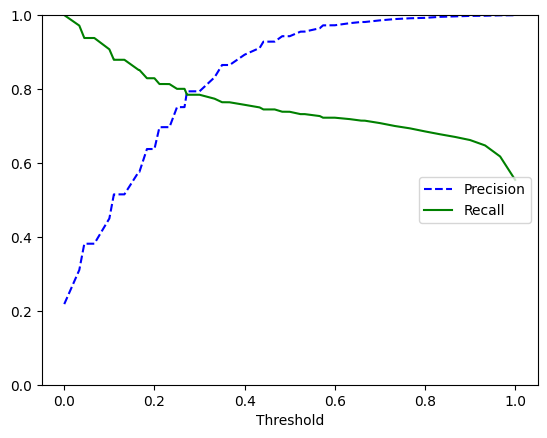

In [249]:
"""
Plot the precision and recall values against different thresholds.

Parameters:
- precisions (array-like): Array of precision values.
- recalls (array-like): Array of recall values.
- thresholds (array-like): Array of threshold values.

Returns:
None
"""

from sklearn.metrics import precision_recall_curve


y_train_scores = cross_val_predict(forest_clf, X_train_prepared_array, y_train, cv=5,
method='predict_proba') # get the out of sample decision scores for the precision recall curve, its a 2D array with the first column being the probability of the negative class and the second column being the probability of the positive class. we need to pass the positive class probabilities to the precision_recall_curve function (the second column)

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores[:,1]) # get the precision, recall and thresholds for the precision recall curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()


There's only 57 thresholds, so the choices arent that much. It's time to set the thresholds.

In [250]:
threshold_1 = thresholds[np.argmax(precisions >= 0.95)]  # get the threshold for 95% precision, which will be used for the low risk loans.

threshold_2 = thresholds[::-1][np.argmax(recalls[::-1] >= 0.9)] # get the threshold for 80% recall, which will be used for high risk loans.

print('Threshold for 95% precision:', threshold_1)
print('Threshold for 90% recall:', threshold_2)


# to make the predictions closer to real world scenarios, this is how we're going to classify the loans as high risk in the app, based on the intent and loan_percent_income:

# education and venture: > 2
# everything else: > 0.7

Threshold for 95% precision: 0.5238888888888888
Threshold for 90% recall: 0.06666666666666667


# Final Evaluation on the Test Set

In [251]:
"""
Evaluate the models for low risk and high risk loans.
Parameters:
- X_test_prepared_array (numpy.ndarray): The prepared array of features for the test set.
- y_test (pandas.Series): The target variable for the test set.
- threshold (float): The threshold for classifying loan status.
- model_clf (estimator): The classifier model for predicting loan status.
- model_reg (estimator): The regressor model for predicting interest rates.
- y_test_interest (pandas.Series): The target variable for interest rates.
Returns:
None
Prints the following evaluation metrics for the RandomForestClassifier model (loan status predictions):
- Accuracy (cross_val_predict)
- Precision
- Recall
- F1 Score
- Confusion Matrix
Prints the following evaluation metrics for the RandomForestRegressor model (interest rate predictions):
- RMSE
"""

# seperate the test set into low risk and high risk loans 
X_test_high_risk = X_test.loc[X_test['loan_intent'].isin(['PERSONAL', 'MEDICAL']) & (X_test['loan_percent_income'] > 0.5) | X_test['loan_intent'].isin(['DEBTCONSOLIDATION', 'HOMEIMPROVEMENT']) & (X_test['loan_percent_income'] > 0.5)] # high risk loans
X_test_low_risk = X_test.loc[~X_test.index.isin(X_test_high_risk.index)] # low risk loans



X_test_low_risk_prepared, y_test_interest_low_risk = pipeline.transform(X_test_low_risk) # transform the low risk loans and get the interest rates
X_test_high_risk_prepared, y_test_interest_high_risk = pipeline.transform(X_test_high_risk) # transform the high risk loans and get the interest rates
X_test_low_risk_prepared_array = X_test_low_risk_prepared.to_numpy() # get the numpy array of the transformed low risk loans
X_test_high_risk_prepared_array = X_test_high_risk_prepared.to_numpy() # get the numpy array of the transformed high risk loans

y_test_low_risk = y_test.loc[X_test_low_risk.index] # get the target variable for the low risk loans
y_test_high_risk = y_test.loc[X_test_high_risk.index] # get the target variable for the high risk loans


# Define a function to evaluate the models
def evaluate_models(X_test_prepared_array, y_test, threshold, model_clf, model_reg, y_test_interest):

    # Make predictions for the loan status using the given threshold
    y_test_pred = (cross_val_predict(model_clf, X_test_prepared_array, y_test, cv=5, method='predict_proba')[:, 1] >= threshold).astype(float)

    # Evaluate the model for the loan status predictions
    print('Evaluation of the RandomForestClassifier model (loan status predictions):\n')
    print('Accuracy (cross_val_predict):', accuracy_score(y_test, y_test_pred))
    print('Precision:', precision_score(y_test, y_test_pred))
    print('Recall:', recall_score(y_test, y_test_pred))
    print('F1 Score:', f1_score(y_test, y_test_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred, normalize='true'))

    # Predict the interest rates
    y_test_interest_pred = cross_val_predict(model_reg, X_test_prepared_array, y_test_interest, cv=5)

    # Evaluate the model for the interest rate predictions
    print('\nEvaluation of the RandomForestRegressor model (interest rate predictions):')
    print('RMSE:', np.sqrt(mean_squared_error(y_test_interest, y_test_interest_pred)),'\n\n')

# Evaluate the model for low risk loans
print('Low Risk Loans:\n')
evaluate_models(X_test_low_risk_prepared_array, y_test_low_risk, threshold_1, forest_clf, forest_reg, y_test_interest_low_risk)

# Evaluate the model for high risk loans
print('\nHigh Risk Loans:\n')
evaluate_models(X_test_high_risk_prepared_array, y_test_high_risk, threshold_2, forest_clf, forest_reg, y_test_interest_high_risk)

# again this evaluation is incomplete because the dataset doesnt represent real world scenarios, but its a good start

Low Risk Loans:

Evaluation of the RandomForestClassifier model (loan status predictions):

Accuracy (cross_val_predict): 0.9279876638396299
Precision: 0.9454022988505747
Recall: 0.7065139584824625
F1 Score: 0.8086849651782057
Confusion Matrix:
 [[0.98879717 0.01120283]
 [0.29348604 0.70651396]]

Evaluation of the RandomForestRegressor model (interest rate predictions):
RMSE: 0.429606199337876 



High Risk Loans:

Evaluation of the RandomForestClassifier model (loan status predictions):

Accuracy (cross_val_predict): 0.78125
Precision: 0.78125
Recall: 1.0
F1 Score: 0.8771929824561403
Confusion Matrix:
 [[0. 1.]
 [0. 1.]]

Evaluation of the RandomForestRegressor model (interest rate predictions):
RMSE: 0.6370567927660121 




It's time to prepare the models for deployment. We shall train/fit the final versions of models on the whole dataset (train and test sets) before exporting them.

In [252]:
X_train_final, y_interest_final = pipeline.fit_transform(credit_data.drop(['loan_status'], axis=1))
y_train_final = credit_data['loan_status']

forest_clf_final = RandomForestClassifier(random_state=42, max_features=10, n_estimators=30, n_jobs=-1)
forest_reg_final = RandomForestRegressor(random_state=42, n_jobs=-1, max_features=15, n_estimators=50, max_depth=10)

forest_clf_final.fit(X_train_final, y_train_final)
forest_reg_final.fit(X_train_final, y_interest_final)

RandomForestRegressor(max_depth=10, max_features=15, n_estimators=50, n_jobs=-1,
                      random_state=42)

Save/Export

In [253]:
"""
Save the trained models, pipeline, and variables to the specified directories.
Parameters:
    forest_clf_final (RandomForestClassifier): The trained RandomForestClassifier model.
    forest_reg_final (RandomForestRegressor): The trained RandomForestRegressor model.
    pipeline (Pipeline): The trained pipeline.
    age_mean (float): The mean value of the 'age' variable.
    age_std (float): The standard deviation of the 'age' variable.
    income_mean (float): The mean value of the 'income' variable.
    income_std (float): The standard deviation of the 'income' variable.
    emp_length_mean (float): The mean value of the 'emp_length' variable.
    emp_length_std (float): The standard deviation of the 'emp_length' variable.
    percent_income_mean (float): The mean value of the 'percent_income' variable.
    percent_income_std (float): The standard deviation of the 'percent_income' variable.
    interest_mean (float): The mean value of the 'interest' variable.
    interest_std (float): The standard deviation of the 'interest' variable.
    threshold_1 (float): The threshold value for precision.
    threshold_2 (float): The threshold value for recall.
    X_train_prepared_df (DataFrame): The transformed train set.
Returns:
    None
"""


import os
import joblib

# Define the directories
model_dir = '../training/models' 
pipeline_dir = '../training/pipeline'
variables_dir = '../training/variables'

# Create the directories if they don't exist
os.makedirs(model_dir, exist_ok=True) # exist_ok=True to avoid raising an exception if the directory already exists
os.makedirs(pipeline_dir, exist_ok=True)
os.makedirs(variables_dir, exist_ok=True)

# Save the RandomForestClassifier model
joblib.dump(forest_clf_final, os.path.join(model_dir, 'forest_clf.pkl')) 

# Save the RandomForestRegressor model
joblib.dump(forest_reg_final, os.path.join(model_dir, 'forest_reg.pkl'))

# Save the pipeline
joblib.dump(pipeline, os.path.join(pipeline_dir, 'pipeline.pkl'))

# Save the mean and standard deviation of the variables
joblib.dump(age_mean, os.path.join(variables_dir, 'age_mean.pkl'))
joblib.dump(age_std, os.path.join(variables_dir, 'age_std.pkl'))
joblib.dump(income_mean, os.path.join(variables_dir, 'income_mean.pkl'))
joblib.dump(income_std, os.path.join(variables_dir, 'income_std.pkl'))
joblib.dump(emp_length_mean, os.path.join(variables_dir, 'emp_length_mean.pkl'))
joblib.dump(emp_length_std, os.path.join(variables_dir, 'emp_length_std.pkl'))
joblib.dump(percent_income_mean, os.path.join(variables_dir, 'percent_income_mean.pkl'))
joblib.dump(percent_income_std, os.path.join(variables_dir, 'percent_income_std.pkl'))
joblib.dump(interest_mean, os.path.join(variables_dir, 'interest_mean.pkl'))
joblib.dump(interest_std, os.path.join(variables_dir, 'interest_std.pkl'))

# Save the thresholds for precision and recall
joblib.dump(threshold_1, os.path.join(variables_dir, 'threshold_1.pkl'))
joblib.dump(threshold_2, os.path.join(variables_dir, 'threshold_2.pkl'))

# Save the column names of the transformed train set
joblib.dump(X_train_prepared_df.columns, os.path.join(variables_dir, 'columns.pkl'))




['../training/variables\\columns.pkl']